Importing and Reading Data

In [1]:
import pandas as pd
import numpy as np
import time
from datetime import datetime as dt
import matplotlib.pyplot as plt
import math
import seaborn as sns
from sklearn.model_selection import train_test_split
import requests
import pandas as pd

pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', 10)

In [2]:
data = pd.DataFrame()
for year in range(2003, 2018):
    for quarter in range(1, 5):
        df = pd.read_csv(f"/Users/admin/Downloads/LGD/data_files/{year}Q{quarter}.csv")
        data = pd.concat([data, df], axis = 0)

/var/folders/pg/z91v_pc17db_f4_zcy_19j0h0000gp/T/ipykernel_89876/2208549058.py:4: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f"/Users/admin/Downloads/LGD/data_files/{year}Q{quarter}.csv")
/var/folders/pg/z91v_pc17db_f4_zcy_19j0h0000gp/T/ipykernel_89876/2208549058.py:4: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f"/Users/admin/Downloads/LGD/data_files/{year}Q{quarter}.csv")
/var/folders/pg/z91v_pc17db_f4_zcy_19j0h0000gp/T/ipykernel_89876/2208549058.py:4: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f"/Users/admin/Downloads/LGD/data_files/{year}Q{quarter}.csv")


In [ ]:
data.columns

In [3]:
data[data['MI_TYPE'].isna()]['OLTV'].describe()

count    388127.000000
mean         72.768357
std           9.774270
min           1.000000
25%          69.000000
50%          76.000000
75%          80.000000
max          97.000000
Name: OLTV, dtype: float64

In [4]:
def get_data_fred(series_id):

    api_key = '8ff9ccdccdab3eb09b6b671419842004'
    url = f'https://api.stlouisfed.org/fred/series/observations?series_id={series_id}&api_key={api_key}&file_type=json'
    response = requests.get(url)

    # Check if the request was successful
    if response.status_code == 200:
        data = response.json()
        
        df = pd.DataFrame(data['observations'])
        df['date'] = pd.to_datetime(df['date'])  # Convert date to datetime format
        df = df[df['value'] != '.']
        df['value'] = df['value'].astype(float)  # Convert value to float
        df = df[['date', 'value']]
        df.columns = ['date', series_id]
        df.rename(columns={'value': series_id}, inplace=True)
        df['date_mm'] = pd.to_datetime(df['date']).dt.month
        df['date_yy'] = pd.to_datetime(df['date']).dt.year
        df['custom_date_format'] = df['date_mm'].astype(str).str[:] + df['date_yy'].astype(str).str[:]
        df = df.drop_duplicates(subset='custom_date_format', keep='first')
    else:
        print(f"Error fetching data: {response.status_code}")
    
    return df[['custom_date_format', series_id]]

def convert_to_custom_date(df):
    value = df.columns.values[1]
    df['DATE'] = pd.to_datetime(df['DATE'])  # Convert date to datetime format
    df.loc[:,df.columns.values[1]] = df[df.columns.values[1]].astype(float)  # Convert value to float
    df['date_mm'] = pd.to_datetime(df['DATE']).dt.month
    df['date_yy'] = pd.to_datetime(df['DATE']).dt.year
    df['custom_date_format'] = df['date_mm'].astype(str).str[:] + df['date_yy'].astype(str).str[:]
    return df[['custom_date_format', value]]

In [5]:
unemp = get_data_fred('UNRATE')
ir = get_data_fred('FEDFUNDS')
cpi = get_data_fred('CPIAUCNS')
cpi['inflation'] = (cpi['CPIAUCNS'].pct_change())*100
vix = get_data_fred('VIXCLS')
personal_savings_rate = get_data_fred('PSAVERT')
housing_starts_data = get_data_fred('HOUST')

hpi_master = pd.read_csv("/Users/admin/Downloads/LGD/Loss-Severity-Modeling-of-Single-Family-Residential-Mortgage-Loans-main/MacroEconomicVariables/HPI_master.csv")
national_hpi = pd.read_csv("/Users/admin/Downloads/LGD/Loss-Severity-Modeling-of-Single-Family-Residential-Mortgage-Loans-main/MacroEconomicVariables/National_HPI.csv")
state_hpi = pd.read_csv("/Users/admin/Downloads/LGD/Loss-Severity-Modeling-of-Single-Family-Residential-Mortgage-Loans-main/MacroEconomicVariables/States_HPI.csv")

national_hpi = convert_to_custom_date(national_hpi)
national_hpi = national_hpi.drop_duplicates(subset='custom_date_format', keep='first')
national_hpi['custom_date_format'] = national_hpi['custom_date_format'].astype(float)

states_hpi = pd.read_csv("/Users/admin/Downloads/LGD/Loss-Severity-Modeling-of-Single-Family-Residential-Mortgage-Loans-main/MacroEconomicVariables/States_HPI.csv")
mortgage_rate = pd.read_csv("/Users/admin/Downloads/LGD/Loss-Severity-Modeling-of-Single-Family-Residential-Mortgage-Loans-main/MacroEconomicVariables/Mortgage.csv")
mortgage_rate = convert_to_custom_date(mortgage_rate)
mortgage_rate = mortgage_rate.drop_duplicates(subset='custom_date_format', keep='first')


In [6]:
state_hpi.columns = [state_hpi.columns[0]] + [col[:2] for col in state_hpi.columns[1:]]
state_hpi['date_mm'] = pd.to_datetime(state_hpi['DATE']).dt.month
state_hpi['date_yy'] = pd.to_datetime(state_hpi['DATE']).dt.year
state_hpi['custom_date_format'] = state_hpi['date_mm'].astype(str).str[:] + state_hpi['date_yy'].astype(str).str[:]
state_hpi.drop(columns = ['DATE', 'date_mm', 'date_yy'], inplace=True)
state_hpi = state_hpi.sort_values(by='custom_date_format')
state_hpi.columns[1:]
state_hpi_copy = state_hpi.copy()
state_hpi_copy = pd.melt(state_hpi_copy, id_vars='custom_date_format', value_name='State_HPI', var_name='STATE')
state_hpi_copy['custom_date_format'] = state_hpi_copy['custom_date_format'].astype(float)

In [7]:
macros = [ir, vix, personal_savings_rate, housing_starts_data, mortgage_rate]
all_macros = unemp.merge(cpi, on='custom_date_format', how='outer')
for macro in macros:
    all_macros = all_macros.merge(macro, on='custom_date_format', how='outer')
all_macros['year'] = all_macros['custom_date_format'].str[-4:]
req_macro_data = all_macros[(all_macros['year'].astype(int) > 1990) & (all_macros['year'].astype(int) < 2023)]
req_macro_data.drop(columns='year',inplace=True)
req_macro_data['custom_date_format'] = req_macro_data['custom_date_format'].astype(float)

/var/folders/pg/z91v_pc17db_f4_zcy_19j0h0000gp/T/ipykernel_89876/3449722008.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  req_macro_data.drop(columns='year',inplace=True)
/var/folders/pg/z91v_pc17db_f4_zcy_19j0h0000gp/T/ipykernel_89876/3449722008.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  req_macro_data['custom_date_format'] = req_macro_data['custom_date_format'].astype(float)


Merge macro variables on ZB_DTE because thats the date of observance of data and merge HPI on orig date

In [8]:
final_data = data.merge(req_macro_data, how='left', left_on='ZB_DTE', right_on='custom_date_format')
final_data = final_data.merge(state_hpi_copy, how='left', left_on= ['ORIG_DATE', 'STATE'], right_on=['custom_date_format', 'STATE'])
final_data = final_data.merge(national_hpi, how='left', left_on='ORIG_DATE', right_on='custom_date_format')
final_data.rename(columns={'CSUSHPISA': 'nationalHPI'}, inplace=True)
final_data = final_data.sort_values(by='ZB_DTE')
data['loan_id'] = data['LOAN_ID']
final_data = final_data.set_index('LOAN_ID')

In [9]:
data = final_data.copy()

Handle Missing Data and Prepare entire dataframe

In [10]:
def handle_all_missing(data):
    missing = data.isna().sum()
    all_vals_missing_cols = missing[missing == len(data)].index.tolist()
    data.drop(columns=all_vals_missing_cols, inplace=True)
    return data

def handle_other_missing(data):
    custom_date_col = data.filter(like='custom_date')
    data.drop(columns = custom_date_col.columns, inplace=True)
    data['CSCORE_C'].fillna(data['CSCORE_B'], inplace=True)
    data['CURR_RATE'].fillna(data['MORTGAGE30US'], inplace=True) #fill current rate with 30yr mortgage rate
    data['State_HPI'].fillna(data['nationalHPI'], inplace=True)
    data['OCLTV'].fillna(data['OLTV'], inplace=True)
    data['NUM_BO'].fillna(math.floor(data['NUM_BO'].mean()), inplace=True)
    data.dropna(subset=['DTI', 'CSCORE_B', 'PPMT_FLG', 'FORECLOSURE_DATE', 'LAST_PAID_INSTALLMENT_DATE'], inplace=True)
    data['FIRST_FLAG'].fillna('N', inplace=True)
    data['MI_PCT'].fillna(data['MI_PCT'].median(), inplace=True)
    data['MI_TYPE'].fillna('N', inplace=True) #if LTV > 0.8, then MI_TYPE will be yes, --> in glossary states N, so not filling with Yes
    data['MOD_FLAG'].fillna('N', inplace=True)
    data['DISPOSITION_DATE'].fillna(data['FORECLOSURE_DATE'], inplace=True)
    cols = (data.filter(like='COSTS').columns).tolist() + (data.filter(like='PROCEEDS').columns).tolist()
    main_cols = cols + ['FORECLOSURE_PRINCIPAL_WRITE_OFF_AMOUNT', 'MISCELLANEOUS_HOLDING_EXPENSES_AND_CREDITS', 'ASSOCIATED_TAXES_FOR_HOLDING_PROPERTY', 'NON_INTEREST_BEARING_UPB', 'PRINCIPAL_FORGIVENESS_AMOUNT']
    data[main_cols] = data[main_cols].fillna(0)
    data.filter(like='COSTS').fillna(0, inplace=True)
    data.filter(like='PROCEEDS').fillna(0, inplace=True)
    data.drop(columns=['PRODUCT', 'PPMT_FLG', 'IO', 'HOMEREADY_PROGRAM_INDICATOR', 'RELOCATION_MORTGAGE_INDICATOR', 
                       'HIGH_BALANCE_LOAN_INDICATOR', 'HIGH_LOAN_TO_VALUE_HLTV_REFINANCE_OPTION_INDICATOR',
                       'CURRENT_UPB', 'TOT_SCHD_PRNCPL', 'PROPERTY_INSPECTION_WAIVER_INDICATOR', 'FORBEARANCE_INDICATOR', 'ADR_TYPE', 'ADR_COUNT', 'ADR_UPB'], inplace=True)
    return data

data = handle_all_missing(data)
data = handle_other_missing(data)
date_cols = ['ORIG_DATE', 'LAST_PAID_INSTALLMENT_DATE', 'FORECLOSURE_DATE', 'DISPOSITION_DATE', 'FIRST_PAY', 'ZB_DTE', 'ACT_PERIOD']
for date_col in date_cols:
    data[date_col] = data[date_col].astype(int).astype(str)
    data[date_col+'_month'] =  pd.to_numeric(data[date_col].str[:-4], errors='coerce')
    data[date_col+'_year'] =  pd.to_numeric(data[date_col].str[-4:], errors='coerce')
data.drop(['ORIG_DATE', 'LAST_PAID_INSTALLMENT_DATE', 'FORECLOSURE_DATE', 'DISPOSITION_DATE', 'FIRST_PAY', 'ACT_PERIOD'], axis= 1, inplace=True)
data = data[data['LAST_UPB'] > 1]

/var/folders/pg/z91v_pc17db_f4_zcy_19j0h0000gp/T/ipykernel_89876/1325325800.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['CSCORE_C'].fillna(data['CSCORE_B'], inplace=True)
/var/folders/pg/z91v_pc17db_f4_zcy_19j0h0000gp/T/ipykernel_89876/1325325800.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting va

In [11]:
data.dropna(inplace=True)

In [12]:
data['Zero_Bal_Code'].value_counts()

Zero_Bal_Code
9.0     353588
3.0      97360
2.0      46068
15.0     35143
Name: count, dtype: int64

Calculate loss

In [13]:
data['INT_COST'] =  (data['DISPOSITION_DATE_year'] * 12 + data['DISPOSITION_DATE_month']- \
                    data['LAST_PAID_INSTALLMENT_DATE_year'] * 12 - data['LAST_PAID_INSTALLMENT_DATE_month']) * \
                    (((data['CURR_RATE'] / 100) - 0.0035) / 12) * (data['LAST_UPB'] - data['NON_INTEREST_BEARING_UPB'])
data['INT_COST'] = data['INT_COST'].fillna(0)
data['INT_COST'] = data['INT_COST'].apply(lambda x: x if x > 0 else 0)

In [14]:
data.columns

Index(['CHANNEL', 'SELLER', 'ORIG_RATE', 'CURR_RATE', 'ORIG_UPB', 'ORIG_TERM',
       'OLTV', 'OCLTV', 'NUM_BO', 'DTI', 'CSCORE_B', 'CSCORE_C', 'FIRST_FLAG',
       'PURPOSE', 'PROP', 'NO_UNITS', 'OCC_STAT', 'STATE', 'MSA', 'ZIP',
       'MI_PCT', 'DLQ_STATUS', 'MOD_FLAG', 'Zero_Bal_Code', 'ZB_DTE',
       'LAST_UPB', 'FORECLOSURE_COSTS',
       'PROPERTY_PRESERVATION_AND_REPAIR_COSTS', 'ASSET_RECOVERY_COSTS',
       'MISCELLANEOUS_HOLDING_EXPENSES_AND_CREDITS',
       'ASSOCIATED_TAXES_FOR_HOLDING_PROPERTY', 'NET_SALES_PROCEEDS',
       'CREDIT_ENHANCEMENT_PROCEEDS', 'REPURCHASES_MAKE_WHOLE_PROCEEDS',
       'OTHER_FORECLOSURE_PROCEEDS', 'NON_INTEREST_BEARING_UPB',
       'PRINCIPAL_FORGIVENESS_AMOUNT', 'MI_TYPE',
       'FORECLOSURE_PRINCIPAL_WRITE_OFF_AMOUNT', 'RE_PROCS_FLAG', 'UNRATE',
       'CPIAUCNS', 'inflation', 'FEDFUNDS', 'VIXCLS', 'PSAVERT', 'HOUST',
       'MORTGAGE30US', 'State_HPI', 'nationalHPI', 'ORIG_DATE_month',
       'ORIG_DATE_year', 'LAST_PAID_INSTALLMENT_DATE_mo

In [15]:
data['loss'] = (data['LAST_UPB'] + \
               data['FORECLOSURE_COSTS'] + \
               data['PROPERTY_PRESERVATION_AND_REPAIR_COSTS'] + \
               data['ASSET_RECOVERY_COSTS'] + \
               data['MISCELLANEOUS_HOLDING_EXPENSES_AND_CREDITS'] + \
               data['ASSOCIATED_TAXES_FOR_HOLDING_PROPERTY'] + \
               data['PRINCIPAL_FORGIVENESS_AMOUNT'] + \
               data['INT_COST'] - \
               data['NET_SALES_PROCEEDS'] - \
               data['CREDIT_ENHANCEMENT_PROCEEDS'] - \
               data['OTHER_FORECLOSURE_PROCEEDS'])
data['loss'] = data['loss'].round(2)
# data['loan_id'] = data['LOAN_ID']
# data.set_index('LOAN_ID',inplace=True)
data['lgd'] = (data['loss']/data['ORIG_UPB'])*100

In [ ]:
data['lgd']

Use the loss cols in conjunction with other cols, something like median of costs wrt to state and then use that value as a predictor for LGD

In [16]:
outlier_loss_df = data[(data['lgd'] < -200) | (data['lgd'] > 200)]

In [17]:
len(outlier_loss_df)

165

In [18]:
data.drop(outlier_loss_df.index, axis=0, inplace=True)

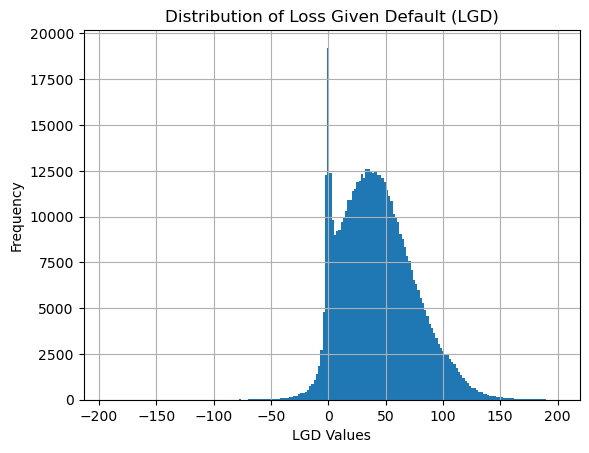

In [19]:
import matplotlib.pyplot as plt

# Plot the histogram
data['lgd'].hist(bins=200)

# Add labels and title
plt.title('Distribution of Loss Given Default (LGD)')
plt.xlabel('LGD Values')
plt.ylabel('Frequency')

# Display the plot
plt.show()
plt.close()


In [20]:
data.columns = data.columns.str.replace(' ', '_')
data['SELLER'].replace(' ', '_', regex=True, inplace=True)
data.drop('OCLTV', axis=1, inplace=True)

/var/folders/pg/z91v_pc17db_f4_zcy_19j0h0000gp/T/ipykernel_89876/175731258.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['SELLER'].replace(' ', '_', regex=True, inplace=True)


In [21]:
loss_cols = ['FORECLOSURE_COSTS', 'PROPERTY_PRESERVATION_AND_REPAIR_COSTS', 'ASSET_RECOVERY_COSTS', 'MISCELLANEOUS_HOLDING_EXPENSES_AND_CREDITS'
             , 'ASSOCIATED_TAXES_FOR_HOLDING_PROPERTY', 'PRINCIPAL_FORGIVENESS_AMOUNT', 'INT_COST', 'NET_SALES_PROCEEDS', 'CREDIT_ENHANCEMENT_PROCEEDS'
             , 'REPURCHASES_MAKE_WHOLE_PROCEEDS', 'OTHER_FORECLOSURE_PROCEEDS', 'Zero_Bal_Code', 'NON_INTEREST_BEARING_UPB'
             , 'FORECLOSURE_PRINCIPAL_WRITE_OFF_AMOUNT', 'FORECLOSURE_DATE_month', 'FORECLOSURE_DATE_year'
             , 'DISPOSITION_DATE_month', 'DISPOSITION_DATE_year', 'ZB_DTE_month', 'ZB_DTE_year', 'loss', 'lgd']

In [25]:
data.columns

Index(['CHANNEL', 'SELLER', 'ORIG_RATE', 'CURR_RATE', 'ORIG_UPB', 'ORIG_TERM',
       'OLTV', 'NUM_BO', 'DTI', 'CSCORE_B', 'CSCORE_C', 'FIRST_FLAG',
       'PURPOSE', 'PROP', 'NO_UNITS', 'OCC_STAT', 'STATE', 'MSA', 'ZIP',
       'MI_PCT', 'DLQ_STATUS', 'MOD_FLAG', 'Zero_Bal_Code', 'ZB_DTE',
       'LAST_UPB', 'FORECLOSURE_COSTS',
       'PROPERTY_PRESERVATION_AND_REPAIR_COSTS', 'ASSET_RECOVERY_COSTS',
       'MISCELLANEOUS_HOLDING_EXPENSES_AND_CREDITS',
       'ASSOCIATED_TAXES_FOR_HOLDING_PROPERTY', 'NET_SALES_PROCEEDS',
       'CREDIT_ENHANCEMENT_PROCEEDS', 'REPURCHASES_MAKE_WHOLE_PROCEEDS',
       'OTHER_FORECLOSURE_PROCEEDS', 'NON_INTEREST_BEARING_UPB',
       'PRINCIPAL_FORGIVENESS_AMOUNT', 'MI_TYPE',
       'FORECLOSURE_PRINCIPAL_WRITE_OFF_AMOUNT', 'RE_PROCS_FLAG', 'UNRATE',
       'CPIAUCNS', 'inflation', 'FEDFUNDS', 'VIXCLS', 'PSAVERT', 'HOUST',
       'MORTGAGE30US', 'State_HPI', 'nationalHPI', 'ORIG_DATE_month',
       'ORIG_DATE_year', 'LAST_PAID_INSTALLMENT_DATE_month',
   

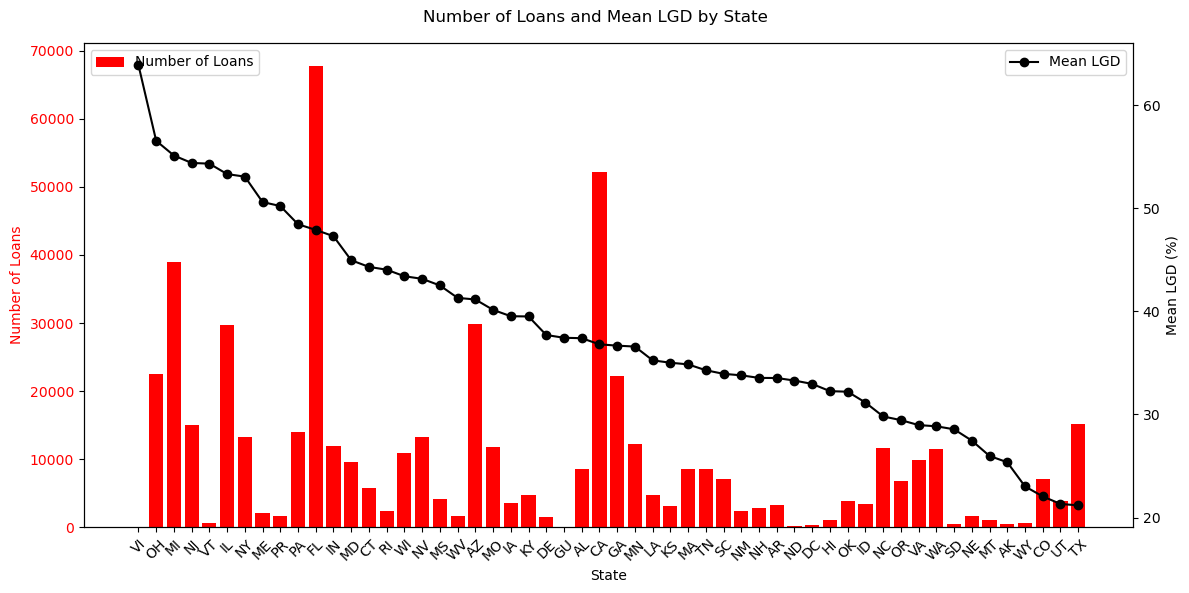

In [77]:
orig_prior_2009 = data[data['ORIG_DATE_year'] <= 2009]
orig_after_2009 = data[data['ORIG_DATE_year'] > 2009]
zb_prior_2009 = data[data['ZB_DTE_year'] <= 2009]
zb_after_2009 = data[data['ZB_DTE_year'] > 2009]

statewise_orig_prior_2009 = pd.DataFrame(orig_prior_2009.groupby(['STATE'])['lgd'].mean())
statewise_orig_after_2009 = pd.DataFrame(orig_after_2009.groupby(['STATE'])['lgd'].mean())
statewise_zb_prior_2009 = pd.DataFrame(zb_prior_2009.groupby(['STATE'])['lgd'].mean())
statewise_zb_after_2009 = pd.DataFrame(zb_after_2009.groupby(['STATE'])['lgd'].mean())

statewise_count = pd.DataFrame(data.groupby(['STATE'])['lgd'].count()).reset_index()
statewise_count.columns = ['STATE', 'count']
statewise_meanLGD = pd.DataFrame(data.groupby(['STATE'])['lgd'].mean()).reset_index()
statewise_meanLGD.columns = ['STATE', 'lgd']
# statewise_count['STATE'] = statewise_count.index
# statewise_meanLGD['STATE'] = statewise_meanLGD.index
statewiseCountAndMean = statewise_count.merge(statewise_meanLGD, on='STATE')
# statewise_lgd.sort_values(by='lgd', ascending=False, inplace=True)
# # statewise_lgd.plot(kind='bar')
# statewise_lgd
# plt.figure(figsize = (25,20))
# statewise_orig_prior_2009.sort_values(by='lgd', ascending=False).plot(kind='bar')
# statewise_orig_after_2009.sort_values(by='lgd', ascending=False).plot(kind='bar')
# df_sorted = statewiseCountAndMean.sort_values(by='lgd')
sorted_indices = np.argsort(statewiseCountAndMean['lgd'])[::-1]
states = [statewiseCountAndMean['STATE'].iloc[i] for i in sorted_indices]
counts = [statewiseCountAndMean['count'].iloc[i] for i in sorted_indices]
lgds = [statewiseCountAndMean['lgd'].iloc[i] for i in sorted_indices]

# Create the figure and axis
fig, ax1 = plt.subplots(figsize=(12, 6))

# Bar plot for count (left axis)
ax1.bar(states, counts, color='red', alpha=1, label='Number of Loans')
ax1.set_xlabel('State')
ax1.set_ylabel('Number of Loans', color='red')
ax1.tick_params(axis='y', labelcolor='red')

plt.xticks(rotation=45)


# Line plot for mean LGD (right axis)
ax2 = ax1.twinx()
ax2.plot(states, lgds, color='black', marker='o', label='Mean LGD')
ax2.set_ylabel('Mean LGD (%)', color='black')
ax2.tick_params(axis='y', labelcolor='black')

plt.xticks(rotation=45)

# Add legends and titles
fig.suptitle('Number of Loans and Mean LGD by State')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()

In [93]:
vi = data[data['STATE'] == 'VI']
vi_analysis = pd.DataFrame(vi.groupby(['OLTV', 'DTI'])['lgd'].mean()).reset_index().sort_values(by='lgd', ascending=False)
vi_analysis

,OLTV,DTI,lgd
9,59.0,58.0,172.287415
70,95.0,35.0,152.334616
14,64.0,26.0,144.678484
72,95.0,40.0,139.633454
38,80.0,19.0,137.297515
...,...,...,...
24,73.0,52.0,0.905190
35,78.0,49.0,-2.964800
1,38.0,43.0,-5.378180
6,54.0,64.0,-11.190414


In [86]:
data['CSCORE_B'].mean()

695.2091602536871

In [83]:
data.columns

Index(['CHANNEL', 'SELLER', 'ORIG_RATE', 'CURR_RATE', 'ORIG_UPB', 'ORIG_TERM',
       'OLTV', 'NUM_BO', 'DTI', 'CSCORE_B', 'CSCORE_C', 'FIRST_FLAG',
       'PURPOSE', 'PROP', 'NO_UNITS', 'OCC_STAT', 'STATE', 'MSA', 'ZIP',
       'MI_PCT', 'DLQ_STATUS', 'MOD_FLAG', 'Zero_Bal_Code', 'ZB_DTE',
       'LAST_UPB', 'FORECLOSURE_COSTS',
       'PROPERTY_PRESERVATION_AND_REPAIR_COSTS', 'ASSET_RECOVERY_COSTS',
       'MISCELLANEOUS_HOLDING_EXPENSES_AND_CREDITS',
       'ASSOCIATED_TAXES_FOR_HOLDING_PROPERTY', 'NET_SALES_PROCEEDS',
       'CREDIT_ENHANCEMENT_PROCEEDS', 'REPURCHASES_MAKE_WHOLE_PROCEEDS',
       'OTHER_FORECLOSURE_PROCEEDS', 'NON_INTEREST_BEARING_UPB',
       'PRINCIPAL_FORGIVENESS_AMOUNT', 'MI_TYPE',
       'FORECLOSURE_PRINCIPAL_WRITE_OFF_AMOUNT', 'RE_PROCS_FLAG', 'UNRATE',
       'CPIAUCNS', 'inflation', 'FEDFUNDS', 'VIXCLS', 'PSAVERT', 'HOUST',
       'MORTGAGE30US', 'State_HPI', 'nationalHPI', 'ORIG_DATE_month',
       'ORIG_DATE_year', 'LAST_PAID_INSTALLMENT_DATE_month',
   

In [62]:
np.argsort(statewiseCountAndMean['lgd'])[::-1]

53    48
52    36
51    23
50    32
49    49
      ..
4      0
3     53
2      5
1     46
0     45
Name: lgd, Length: 54, dtype: int64

In [56]:
statewiseCountAndMean

,STATE,count,lgd
0,AK,460,25.368334
1,AL,8553,37.397554
2,AR,3304,33.536900
3,AZ,29920,41.153681
4,CA,52180,36.801943
...,...,...,...
49,VT,667,54.322951
50,WA,11543,28.854060
51,WI,10874,43.404301
52,WV,1662,41.306147


In [ ]:
cols = (data.filter(like='COST').columns).tolist() + (data.filter(like='PROCEEDS').columns).tolist()
main_cols = cols + ['FORECLOSURE_PRINCIPAL_WRITE_OFF_AMOUNT', 'MISCELLANEOUS_HOLDING_EXPENSES_AND_CREDITS', 'ASSOCIATED_TAXES_FOR_HOLDING_PROPERTY', 'NON_INTEREST_BEARING_UPB', 'PRINCIPAL_FORGIVENESS_AMOUNT']

In [ ]:
data.columns

In [ ]:
data_2009 = data[data['ZB_DTE'] <= '122009']
data_2009_2017 = data[data['ZB_DTE'] > '122009']

In [ ]:
import matplotlib.pyplot as plt

# Plot the histogram
data_2009['lgd'].hist(bins=200)
# data_2009[(data_2009['ZB_DTE'] > '122005') & (data_2009['ZB_DTE'] < '122008')]['lgd'].hist(bins=200)


# Add labels and title
plt.title('Distribution of Loss Given Default (LGD) before 2009')
plt.xlabel('LGD Values')
plt.ylabel('Frequency')

# Display the plot
plt.show()
plt.close()


In [ ]:
import matplotlib.pyplot as plt

# Plot the histogram
# data_2009_2017[(data_2009_2017['ZB_DTE'] > '122008') & (data_2009_2017['ZB_DTE'] < '122011')]['lgd'].hist(bins=200)
data_2009_2017['lgd'].hist(bins=200)


# Add labels and title
plt.title('Distribution of Loss Given Default (LGD) after 2009')
plt.xlabel('LGD Values')
plt.ylabel('Frequency')

# Display the plot
plt.show()
plt.close()


In [ ]:
n = len(data)
train_data = data.iloc[:450000]
test_data = data.iloc[450000:]
train_data_2009 = data_2009.iloc[:100000]
test_data_2009 = data_2009.iloc[100000:]
train_data_2009_2017 = data_2009_2017.iloc[:350000]
test_data_2009_2017 = data_2009_2017.iloc[350000:]

y_test_2009, y_test_2009_2017  = test_data_2009['lgd'], test_data_2009_2017['lgd']

In [ ]:
y_test_all = test_data['lgd']

In [ ]:
cols = (data.filter(like='COST').columns).tolist() + (data.filter(like='PROCEEDS').columns).tolist()
main_cols = cols + ['FORECLOSURE_PRINCIPAL_WRITE_OFF_AMOUNT', 'MISCELLANEOUS_HOLDING_EXPENSES_AND_CREDITS', 'ASSOCIATED_TAXES_FOR_HOLDING_PROPERTY', 'NON_INTEREST_BEARING_UPB', 'PRINCIPAL_FORGIVENESS_AMOUNT']

In [ ]:
loss_indicator_for_test_9 = pd.DataFrame(train_data_2009.groupby(['STATE'])['FORECLOSURE_COSTS'].mean())
loss_indicator_for_test_after = pd.DataFrame(train_data_2009_2017.groupby(['STATE'])['FORECLOSURE_COSTS'].mean())
loss_indicator_for_test_all = pd.DataFrame(train_data.groupby(['STATE'])['FORECLOSURE_COSTS'].mean())


main_cols=main_cols[1:]
for col in main_cols:
    x_all = pd.DataFrame(train_data.groupby(['STATE'])[col].mean())
    x_9 = pd.DataFrame(train_data_2009.groupby(['STATE'])[col].mean())
    x_after = pd.DataFrame(train_data_2009_2017.groupby(['STATE'])[col].mean())
    loss_indicator_for_test_all = pd.merge(loss_indicator_for_test_all, x_all, how='left', on = 'STATE')
    loss_indicator_for_test_9 = pd.merge(loss_indicator_for_test_9, x_9, how='left', on = 'STATE')
    loss_indicator_for_test_after = pd.merge(loss_indicator_for_test_after, x_after, how='left', on = 'STATE')

X_test = pd.merge(test_data.drop(columns=loss_cols), loss_indicator_for_test_all, how='left', on='STATE')
object_col_df = X_test.select_dtypes(include=['object'])
object_col_df.head()
X_test = pd.get_dummies(X_test, columns=object_col_df.drop(columns=['ZB_DTE', 'SELLER', 'DLQ_STATUS']).columns, dtype='int')

X_test_2009 = pd.merge(test_data_2009.drop(columns=loss_cols), loss_indicator_for_test_9, how='left', on='STATE')
object_col_df = X_test_2009.select_dtypes(include=['object'])
object_col_df.head()
X_test_2009 = pd.get_dummies(X_test_2009, columns=object_col_df.drop(columns=['ZB_DTE', 'SELLER', 'DLQ_STATUS']).columns, dtype='int')

X_test_2009_2017 = pd.merge(test_data_2009_2017.drop(columns=loss_cols), loss_indicator_for_test_after, how = 'left', on='STATE')
object_col_df = X_test_2009_2017.select_dtypes(include=['object'])
object_col_df.head()
X_test_2009_2017 = pd.get_dummies(X_test_2009_2017, columns=object_col_df.drop(columns=['ZB_DTE', 'SELLER', 'DLQ_STATUS']).columns, dtype='int')

In [ ]:
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error, mean_absolute_error
from sklearn.linear_model import LinearRegression

def run_linear_regression_model(window_size, test_size, train_data):

    n = len(train_data)

    # Lists to store metrics and lin_models
    mse_list = []
    r2_list = []
    mape_list = []
    test_and_preds_list = []
    mae_list = []

    # Sliding window training loop
    for start in range(window_size, n, test_size):
        training_1 = train_data.iloc[:start]  # Define the training window
        dev_1 = train_data.iloc[start:start+test_size]  # Define the next test set

        # Create loss indicator for the training data
        loss_indicator_for_train = pd.DataFrame(training_1.groupby(['STATE'])['FORECLOSURE_COSTS'].mean())

        # Iterate over main columns to calculate mean and merge for training data
        loss_indicator_for_training_1 = loss_indicator_for_train.copy()  # Initialize the loss indicator
        for col in main_cols:
            x = pd.DataFrame(training_1.groupby(['STATE'])[col].mean())
            loss_indicator_for_training_1 = pd.merge(loss_indicator_for_training_1, x, how='left', on='STATE')

        # Apply the same transformations on both training and test data
        X_training_1 = pd.merge(training_1.drop(columns=loss_cols), loss_indicator_for_training_1, how='left', on='STATE')
        y_training_1 = training_1['lgd']

        X_dev_1 = pd.merge(dev_1.drop(columns=loss_cols), loss_indicator_for_training_1, how='left', on='STATE')
        y_dev_1 = dev_1['lgd']

        # Convert categorical features using one-hot encoding (excluding 'ZB_DTE' and 'SELLER')
        object_cols = X_training_1.select_dtypes(include=['object']).columns.drop(['ZB_DTE', 'SELLER', 'DLQ_STATUS'])
        X_training_1 = pd.get_dummies(X_training_1, columns=object_cols, dtype='int')
        X_dev_1 = pd.get_dummies(X_dev_1, columns=object_cols, dtype='int')

        X_training_1.drop(columns=['ZB_DTE', 'SELLER', 'DLQ_STATUS'], inplace=True)
        X_dev_1.drop(columns=['ZB_DTE', 'SELLER', 'DLQ_STATUS'], inplace=True)

        # Ensure train and test have the same columns after encoding
        X_training_1, X_dev_1 = X_training_1.align(X_dev_1, join='left', axis=1, fill_value=0)

        # Initialize and train the Linear Regression lin_model
        lin_model = LinearRegression()
        lin_model.fit(X_training_1, y_training_1)

        y_pred = lin_model.predict(X_dev_1)
        y_pred_series = pd.Series(y_pred, index=y_dev_1.index)
        test_and_preds = pd.concat([y_dev_1, y_pred_series], axis=1)
        test_and_preds.columns = ['actual', 'predicted']
        test_and_preds_list.append(test_and_preds)

        # Calculate MSE, R-squared, MAPE, and MAE
        mse = mean_squared_error(y_dev_1, y_pred)
        r2 = r2_score(y_dev_1, y_pred)
        mape = mean_absolute_percentage_error(y_dev_1, y_pred)
        mae = mean_absolute_error(y_dev_1, y_pred)
        
        # Store metrics and lin_model
        mse_list.append(mse)
        r2_list.append(r2)
        mape_list.append(mape)
        mae_list.append(mae)

        print(f"Mean Squared Error for this window (start {start}): {mse}")
        print(f"Mean Absolute Error for this window (start {start}): {mae}")
        print(f"Mean % Error for this window (start {start}): {mape}")
        print(f"R² for this window (start {start}): {r2}")

    return test_and_preds_list, mse_list, r2_list, mape_list, mae_list, lin_model


In [ ]:
test_and_preds_list_9, mse_list_9, r2_list_9, mape_list_9, mae_list_9, lin_model_9 = run_linear_regression_model(20000, 10000, train_data_2009)
test_and_preds_list_9_after, mse_list_9_after, r2_list_9_after, mape_list_9_after, mae_list_9_after, lin_model_after = run_linear_regression_model(50000, 50000, train_data_2009_2017)
test_and_preds_all, mse_list_all, r2_list_all, mape_list_all, mae_list_all, lin_model_all = run_linear_regression_model(100000, 50000, train_data)

In [ ]:
import pandas as pd

# Combine predictions for each time period into a DataFrame
lin_df_preds = pd.DataFrame({
    "lin_actual_9": pd.concat([df["actual"] for df in test_and_preds_list_9], axis=0).reset_index(drop=True),
    "lin_predicted_9": pd.concat([df["predicted"] for df in test_and_preds_list_9], axis=0).reset_index(drop=True),
    "lin_actual_after": pd.concat([df["actual"] for df in test_and_preds_list_9_after], axis=0).reset_index(drop=True),
    "lin_predicted_after": pd.concat([df["predicted"] for df in test_and_preds_list_9_after], axis=0).reset_index(drop=True),
    "lin_actual_all": pd.concat([df["actual"] for df in test_and_preds_all], axis=0).reset_index(drop=True),
    "lin_predicted_all": pd.concat([df["predicted"] for df in test_and_preds_all], axis=0).reset_index(drop=True)
})

lin_df_preds

In [ ]:
import numpy as np
import pandas as pd

# Find the maximum length among all metric lists
max_length = max(
    len(mse_list_9), len(mae_list_9), len(mape_list_9), len(r2_list_9),
    len(mse_list_9_after), len(mae_list_9_after), len(mape_list_9_after), len(r2_list_9_after),
    len(mse_list_all), len(mae_list_all), len(mape_list_all), len(r2_list_all)
)

# Function to pad lists with NaN values to match the max_length
def pad_list(metric_list, max_length):
    return metric_list + [np.nan] * (max_length - len(metric_list))

# Create a DataFrame to store metrics with padded lists
lin_df_metrics = pd.DataFrame({
    "mse_9": pad_list(mse_list_9, max_length),
    "mae_9": pad_list(mae_list_9, max_length),
    "mape_9": pad_list(mape_list_9, max_length),
    "r2_9": pad_list(r2_list_9, max_length),
    "mse_after": pad_list(mse_list_9_after, max_length),
    "mae_after": pad_list(mae_list_9_after, max_length),
    "mape_after": pad_list(mape_list_9_after, max_length),
    "r2_after": pad_list(r2_list_9_after, max_length),
    "mse_all": pad_list(mse_list_all, max_length),
    "mae_all": pad_list(mae_list_all, max_length),
    "mape_all": pad_list(mape_list_all, max_length),
    "r2_all": pad_list(r2_list_all, max_length)
})
lin_df_metrics


In [ ]:
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error, mean_absolute_error
import xgboost as xgb

def run_xgb_model(window_size, test_size, train_data):

    n = len(train_data)

    # Lists to store metrics and xgb_models
    mse_list = []
    r2_list = []
    mape_list = []
    test_and_preds_list = []
    mae_list = []

    # Sliding window training loop
    for start in range(window_size, n, test_size):
        training_1 = train_data.iloc[:start]  # Define the training window
        dev_1 = train_data.iloc[start:start+test_size]  # Define the next test set

        # Create loss indicator for the training data
        loss_indicator_for_train = pd.DataFrame(training_1.groupby(['STATE'])['FORECLOSURE_COSTS'].mean())

        # Iterate over main columns to calculate mean and merge for training data
        loss_indicator_for_training_1 = loss_indicator_for_train.copy()  # Initialize the loss indicator
        for col in main_cols:
            x = pd.DataFrame(training_1.groupby(['STATE'])[col].mean())
            loss_indicator_for_training_1 = pd.merge(loss_indicator_for_training_1, x, how='left', on='STATE')

        # Apply the same transformations on both training and test data
        X_training_1 = pd.merge(training_1.drop(columns=loss_cols), loss_indicator_for_training_1, how='left', on='STATE')
        y_training_1 = training_1['lgd']

        X_dev_1 = pd.merge(dev_1.drop(columns=loss_cols), loss_indicator_for_training_1, how='left', on='STATE')
        y_dev_1 = dev_1['lgd']

        # Convert categorical features using one-hot encoding (excluding 'ZB_DTE' and 'SELLER')
        object_cols = X_training_1.select_dtypes(include=['object']).columns.drop(['ZB_DTE', 'SELLER', 'DLQ_STATUS'])
        X_training_1 = pd.get_dummies(X_training_1, columns=object_cols, dtype='int')
        X_dev_1 = pd.get_dummies(X_dev_1, columns=object_cols, dtype='int')

        X_training_1.drop(columns = ['ZB_DTE', 'SELLER', 'DLQ_STATUS'], inplace=True)
        X_dev_1.drop(columns = ['ZB_DTE', 'SELLER', 'DLQ_STATUS'], inplace=True)

        # Ensure train and test have the same columns after encoding
        X_training_1, X_dev_1 = X_training_1.align(X_dev_1, join='left', axis=1, fill_value=0)

        # XGBoost xgb_model parameters
        params = {
            'objective': 'reg:squarederror',  # Using regression as the task is LGD prediction
            'n_estimators': 500,
            'learning_rate': 0.5,
            'max_depth': 3,
            'random_state': 42
            }

        # Initialize and train the XGBoost xgb_model
        xgb_model = xgb.XGBRegressor(**params)
        xgb_model.fit(X_training_1, y_training_1)

        y_pred = xgb_model.predict(X_dev_1)
        y_pred_series = pd.Series(y_pred, index=y_dev_1.index)
        test_and_preds = pd.concat([y_dev_1, y_pred_series], axis=1)
        test_and_preds.columns = ['actual', 'predicted']
        test_and_preds_list.append(test_and_preds)

        # Calculate MSE and R-squared
        mse = mean_squared_error(y_dev_1, y_pred)
        r2 = r2_score(y_dev_1, y_pred)
        mape = mean_absolute_percentage_error(y_dev_1, y_pred)
        mae = mean_absolute_error(y_dev_1, y_pred)
        
        # Store metrics and xgb_model
        mse_list.append(mse)
        r2_list.append(r2)
        mape_list.append(mape)
        mae_list.append(mae)

        print(f"Mean Squared Error for this window (start {start}): {mse}")
        print(f"Mean absolute Error for this window (start {start}): {mae}")
        print(f"Mean % Error for this window (start {start}): {mape}")
        print(f"R² for this window (start {start}): {r2}")

    return test_and_preds_list, mse_list, r2_list, mape_list, mae_list, xgb_model


In [ ]:
xgb_test_and_preds_list_9, xgb_mse_list_9, xgb_r2_list_9, xgb_mape_list_9, xgb_mae_list_9, xgb_model_9 = run_xgb_model(20000, 10000, train_data_2009)
xgb_test_and_preds_list_9_after, xgb_mse_list_9_after, xgb_r2_list_9_after, xgb_mape_list_9_after, xgb_mae_list_9_after, xgb_model_after = run_xgb_model(50000, 50000, train_data_2009_2017)
xgb_test_and_preds_all, xgb_mse_list_all, xgb_r2_list_all, xgb_mape_list_all, xgb_mae_list_all, xgb_model_all = run_xgb_model(100000, 50000, train_data)

In [ ]:
xgb_df_preds = pd.DataFrame({
    "xgb_actual_9": pd.concat([df["actual"] for df in xgb_test_and_preds_list_9], axis=0).reset_index(drop=True),
    "xgb_predicted_9": pd.concat([df["predicted"] for df in xgb_test_and_preds_list_9], axis=0).reset_index(drop=True),
    "xgb_actual_after": pd.concat([df["actual"] for df in xgb_test_and_preds_list_9_after], axis=0).reset_index(drop=True),
    "xgb_predicted_after": pd.concat([df["predicted"] for df in xgb_test_and_preds_list_9_after], axis=0).reset_index(drop=True),
    "xgb_actual_all": pd.concat([df["actual"] for df in xgb_test_and_preds_all], axis=0).reset_index(drop=True),
    "xgb_predicted_all": pd.concat([df["predicted"] for df in xgb_test_and_preds_all], axis=0).reset_index(drop=True)
})
# Find the maximum length among all metric lists
max_length = max(
    len(xgb_mse_list_9), len(xgb_mae_list_9), len(xgb_mape_list_9), len(xgb_r2_list_9),
    len(xgb_mse_list_9_after), len(xgb_mae_list_9_after), len(xgb_mape_list_9_after), len(xgb_r2_list_9_after),
    len(xgb_mse_list_all), len(xgb_mae_list_all), len(xgb_mape_list_all), len(xgb_r2_list_all)
)

# Function to pad lists with NaN values to match the max_length
def pad_list(metric_list, max_length):
    return metric_list + [np.nan] * (max_length - len(metric_list))

# Create a DataFrame to store metrics with padded lists
xgb_df_metrics = pd.DataFrame({
   "xgb_mse_9": pad_list(xgb_mse_list_9, max_length),
   "xgb_mae_9": pad_list(xgb_mae_list_9, max_length),
   "xgb_mape_9": pad_list(xgb_mape_list_9, max_length),
    "xgb_r2_9": pad_list(xgb_r2_list_9, max_length),
   "xgb_mse_after": pad_list(xgb_mse_list_9_after, max_length),
   "xgb_mae_after": pad_list(xgb_mae_list_9_after, max_length),
   "xgb_mape_after": pad_list(xgb_mape_list_9_after, max_length),
    "xgb_r2_after": pad_list(xgb_r2_list_9_after, max_length),
   "xgb_mse_all": pad_list(xgb_mse_list_all, max_length),
   "xgb_mae_all": pad_list(xgb_mae_list_all, max_length),
   "xgb_mape_all": pad_list(xgb_mape_list_all, max_length),
    "xgb_r2_all": pad_list(xgb_r2_list_all, max_length)
})
xgb_df_metrics


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Reset index to avoid potential gaps and ensure a continuous index range
lin_df_preds_before = lin_df_preds[['lin_actual_9', 'lin_predicted_9']].dropna().reset_index(drop=True)
lin_df_preds_after = lin_df_preds[['lin_actual_after', 'lin_predicted_after']].dropna().reset_index(drop=True)
xgb_df_preds_before = xgb_df_preds[['xgb_actual_9', 'xgb_predicted_9']].dropna().reset_index(drop=True)
xgb_df_preds_after = xgb_df_preds[['xgb_actual_after', 'xgb_predicted_after']].dropna().reset_index(drop=True)

# Plot actual vs. predicted values for both Linear Regression and XGBoost before and after
fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharex=True, sharey=True)
fig.suptitle('Actual vs. Predicted Values - Linear Regression and XGBoost')

# Linear Regression - Before
sns.lineplot(data=lin_df_preds_before, x=lin_df_preds_before.index, y='lin_actual_9', ax=axes[0, 0], label="Actual")
sns.lineplot(data=lin_df_preds_before, x=lin_df_preds_before.index, y='lin_predicted_9', ax=axes[0, 0], label="Predicted")
axes[0, 0].set_title("Linear Regression - Before")

# Linear Regression - After
sns.lineplot(data=lin_df_preds_after, x=lin_df_preds_after.index, y='lin_actual_after', ax=axes[0, 1], label="Actual")
sns.lineplot(data=lin_df_preds_after, x=lin_df_preds_after.index, y='lin_predicted_after', ax=axes[0, 1], label="Predicted")
axes[0, 1].set_title("Linear Regression - After")

# XGBoost - Before
sns.lineplot(data=xgb_df_preds_before, x=xgb_df_preds_before.index, y='xgb_actual_9', ax=axes[1, 0], label="Actual")
sns.lineplot(data=xgb_df_preds_before, x=xgb_df_preds_before.index, y='xgb_predicted_9', ax=axes[1, 0], label="Predicted")
axes[1, 0].set_title("XGBoost - Before")

# XGBoost - After
sns.lineplot(data=xgb_df_preds_after, x=xgb_df_preds_after.index, y='xgb_actual_after', ax=axes[1, 1], label="Actual")
sns.lineplot(data=xgb_df_preds_after, x=xgb_df_preds_after.index, y='xgb_predicted_after', ax=axes[1, 1], label="Predicted")
axes[1, 1].set_title("XGBoost - After")

plt.tight_layout()
plt.show()


In [ ]:
x_limits = (-200, 200)  # Set this based on the observed x-axis range
y_limits = (0, 0.02)    # Set this based on the observed y-axis range

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Density Estimation - Linear Regression and XGBoost')

sns.kdeplot(lin_df_preds['lin_actual_9'], ax=axes[0, 0], label="Actual", shade=True)
sns.kdeplot(lin_df_preds['lin_predicted_9'], ax=axes[0, 0], label="Predicted", shade=True)
axes[0, 0].set_title("Linear Regression - Before")
axes[0, 0].set_xlim(x_limits)
axes[0, 0].set_ylim(y_limits)

# Plot for Linear Regression - After
sns.kdeplot(lin_df_preds['lin_actual_after'], ax=axes[0, 1], label="Actual", shade=True)
sns.kdeplot(lin_df_preds['lin_predicted_after'], ax=axes[0, 1], label="Predicted", shade=True)
axes[0, 1].set_title("Linear Regression - After")
axes[0, 1].set_xlim(x_limits)
axes[0, 1].set_ylim(y_limits)

# Plot for XGBoost - Before
sns.kdeplot(xgb_df_preds['xgb_actual_9'], ax=axes[1, 0], label="Actual", shade=True)
sns.kdeplot(xgb_df_preds['xgb_predicted_9'], ax=axes[1, 0], label="Predicted", shade=True)
axes[1, 0].set_title("XGBoost - Before")
axes[1, 0].set_xlim(x_limits)
axes[1, 0].set_ylim(y_limits)

# Plot for XGBoost - After
sns.kdeplot(xgb_df_preds['xgb_actual_after'], ax=axes[1, 1], label="Actual", shade=True)
sns.kdeplot(xgb_df_preds['xgb_predicted_after'], ax=axes[1, 1], label="Predicted", shade=True)
axes[1, 1].set_title("XGBoost - After")
axes[1, 1].set_xlim(x_limits)
axes[1, 1].set_ylim(y_limits)

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [ ]:
# Prepare the metrics DataFrame for easy plotting
metrics_df = pd.DataFrame({
    "Model": ["Linear - Before", "Linear - After", "XGBoost - Before", "XGBoost - After"],
    "MSE": [lin_df_metrics["mse_9"].mean(), lin_df_metrics["mse_after"].mean(),
            xgb_df_metrics["xgb_mse_9"].mean(), xgb_df_metrics["xgb_mse_after"].mean()],
    "MAE": [lin_df_metrics["mae_9"].mean(), lin_df_metrics["mae_after"].mean(),
            xgb_df_metrics["xgb_mae_9"].mean(), xgb_df_metrics["xgb_mae_after"].mean()],
    # "MAPE": [lin_df_metrics["mape_9"].mean(), lin_df_metrics["mape_after"].mean(),
    #          xgb_df_metrics["xgb_mape_9"].mean(), xgb_df_metrics["xgb_mape_after"].mean()],
    "R2": [lin_df_metrics["r2_9"].mean(), lin_df_metrics["r2_after"].mean(),
           xgb_df_metrics["xgb_r2_9"].mean(), xgb_df_metrics["xgb_r2_after"].mean()]
})

# Plot each metric
metrics_df.set_index("Model")[["MAE", "R2"]].plot(kind="bar", subplots=True, layout=(2, 2), figsize=(12, 10), legend=True)
plt.suptitle("Metric Comparison for Linear Regression and XGBoost Models")
plt.tight_layout()
plt.show()


In [ ]:
# X_test_2009_2017[lin_model_9.feature_names_in_]
X_test_2009['STATE_GU'] = 0
X_test_2009_2017['MI_TYPE_3.0'] = 0

In [ ]:
y_lin_pred_9 = lin_model_9.predict(X_test_2009[lin_model_9.feature_names_in_])
mse_lin_9 = mean_squared_error(y_test_2009, y_lin_pred_9)
r2_lin_9 = r2_score(y_test_2009, y_lin_pred_9)
mape_lin_9 = mean_absolute_percentage_error(y_test_2009, y_lin_pred_9)
mae_lin_9 = mean_absolute_error(y_test_2009, y_lin_pred_9)

# Create DataFrame for predictions "before 2009"
lin_test_and_preds_9 = pd.DataFrame({
    'actual_9': y_test_2009,
    'predicted_lin_9': y_lin_pred_9
})

print("Linear Regression Metrics - Before 2009:")
print(f"MSE: {mse_lin_9}, R²: {r2_lin_9}, MAPE: {mape_lin_9}, MAE: {mae_lin_9}")

y_lin_pred_after = lin_model_after.predict(X_test_2009_2017[lin_model_after.feature_names_in_])
mse_lin_after = mean_squared_error(y_test_2009_2017, y_lin_pred_after)
r2_lin_after = r2_score(y_test_2009_2017, y_lin_pred_after)
mape_lin_after = mean_absolute_percentage_error(y_test_2009_2017, y_lin_pred_after)
mae_lin_after = mean_absolute_error(y_test_2009_2017, y_lin_pred_after)

# Create DataFrame for predictions "before 2009"
lin_test_and_preds_after = pd.DataFrame({
    'actual_after': y_test_2009_2017,
    'predicted_lin_after': y_lin_pred_after
})

print("Linear Regression Metrics - After 2009:")
print(f"MSE: {mse_lin_after}, R²: {r2_lin_after}, MAPE: {mape_lin_after}, MAE: {mae_lin_after}")

y_lin_pred_all = lin_model_all.predict(X_test[lin_model_all.feature_names_in_])
mse_lin_all = mean_squared_error(y_test_all, y_lin_pred_all)
r2_lin_all = r2_score(y_test_all, y_lin_pred_all)
mape_lin_all = mean_absolute_percentage_error(y_test_all, y_lin_pred_all)
mae_lin_all = mean_absolute_error(y_test_all, y_lin_pred_all)

# Create DataFrame for predictions "before 2009"
lin_test_and_preds_all = pd.DataFrame({
    'actual_all': y_test_all,
    'predicted_lin_all': y_lin_pred_all
})

print("linear Regression Metrics - all data:")
print(f"MSE: {mse_lin_all}, R²: {r2_lin_all}, MAPE: {mape_lin_all}, MAE: {mae_lin_all}")


In [ ]:
y_xgb_pred_9 = xgb_model_9.predict(X_test_2009[xgb_model_9.feature_names_in_])
mse_xgb_9 = mean_squared_error(y_test_2009, y_xgb_pred_9)
r2_xgb_9 = r2_score(y_test_2009, y_xgb_pred_9)
mape_xgb_9 = mean_absolute_percentage_error(y_test_2009, y_xgb_pred_9)
mae_xgb_9 = mean_absolute_error(y_test_2009, y_xgb_pred_9)

# Create DataFrame for predictions "before 2009"
xgb_test_and_preds_9 = pd.DataFrame({
    'actual_9': y_test_2009,
    'predicted_xgb_9': y_xgb_pred_9
})

print("xgbear Regression Metrics - Before 2009:")
print(f"MSE: {mse_xgb_9}, R²: {r2_xgb_9}, MAPE: {mape_xgb_9}, MAE: {mae_xgb_9}")

y_xgb_pred_after = xgb_model_after.predict(X_test_2009_2017[xgb_model_after.feature_names_in_])
mse_xgb_after = mean_squared_error(y_test_2009_2017, y_xgb_pred_after)
r2_xgb_after = r2_score(y_test_2009_2017, y_xgb_pred_after)
mape_xgb_after = mean_absolute_percentage_error(y_test_2009_2017, y_xgb_pred_after)
mae_xgb_after = mean_absolute_error(y_test_2009_2017, y_xgb_pred_after)

# Create DataFrame for predictions "before 2009"
xgb_test_and_preds_after = pd.DataFrame({
    'actual_after': y_test_2009_2017,
    'predicted_xgb_after': y_xgb_pred_after
})

print("xgbear Regression Metrics - After 2009:")
print(f"MSE: {mse_xgb_after}, R²: {r2_xgb_after}, MAPE: {mape_xgb_after}, MAE: {mae_xgb_after}")

y_xgb_pred_all = xgb_model_all.predict(X_test[xgb_model_all.feature_names_in_])
mse_xgb_all = mean_squared_error(y_test_all, y_xgb_pred_all)
r2_xgb_all = r2_score(y_test_all, y_xgb_pred_all)
mape_xgb_all = mean_absolute_percentage_error(y_test_all, y_xgb_pred_all)
mae_xgb_all = mean_absolute_error(y_test_all, y_xgb_pred_all)

# Create DataFrame for predictions "before 2009"
xgb_test_and_preds_all = pd.DataFrame({
    'actual_all': y_test_all,
    'predicted_xgb_all': y_xgb_pred_all
})

print("xgb Regression Metrics - all data:")
print(f"MSE: {mse_xgb_all}, R²: {r2_xgb_all}, MAPE: {mape_xgb_all}, MAE: {mae_xgb_all}")

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have calculated the metrics as follows:
# Linear Regression - Before 2009
mse_lin_9, r2_lin_9, mape_lin_9, mae_lin_9

# Linear Regression - After 2009
mse_lin_after, r2_lin_after, mape_lin_after, mae_lin_after

# XGBoost - Before 2009
mse_xgb_9, r2_xgb_9, mape_xgb_9, mae_xgb_9

# XGBoost - After 2009
mse_xgb_after, r2_xgb_after, mape_xgb_after, mae_xgb_after

# Prepare data for R² and MAE
r2_values = [r2_lin_9, r2_lin_after, r2_xgb_9, r2_xgb_after]
mae_values = [mae_lin_9, mae_lin_after, mae_xgb_9, mae_xgb_after]

# Labels for the bars
labels = ['Linear - Before 2009', 'Linear - After 2009', 'XGBoost - Before 2009', 'XGBoost - After 2009']

# Bar width
bar_width = 0.4
index = np.arange(len(labels))

# Plotting R² and MAE on separate subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# R² subplot
axes[0].bar(index, r2_values, bar_width, color='skyblue')
axes[0].set_xlabel('Model and Period')
axes[0].set_ylabel('R²')
axes[0].set_title('R² Comparison')
axes[0].set_xticks(index)
axes[0].set_xticklabels(labels, rotation=45, ha="right")

# MAE subplot
axes[1].bar(index, mae_values, bar_width, color='salmon')
axes[1].set_xlabel('Model and Period')
axes[1].set_ylabel('MAE')
axes[1].set_title('MAE Comparison')
axes[1].set_xticks(index)
axes[1].set_xticklabels(labels, rotation=45, ha="right")

plt.tight_layout()
plt.show()


In [ ]:
# import pandas as pd
# import matplotlib.pyplot as plt
# import numpy as np
# import xgboost as xgb  # assuming you have xgboost installed

# # Assuming lin_model_all and xgb_model_all are the trained models for Linear Regression and XGBoost, respectively.

# ### 1. Linear Regression Feature Importances
# # Get the absolute values of coefficients
# lin_coef_all = pd.Series(np.abs(lin_model_all.coef_), index=lin_model_all.feature_names_in_)
# lin_coef_all = lin_coef_all.sort_values(ascending=False)

# ### 2. XGBoost Feature Importances
# # Get feature importances from the trained XGBoost model
# xgb_importance_all = pd.Series(xgb_model_all.feature_importances_, index=xgb_model_all.feature_names_in_)
# xgb_importance_all = xgb_importance_all.sort_values(ascending=False)
# xgb_importance_all_gain = pd.Series(xgb_model_all.get_booster().get_score(importance_type='weight'), index=xgb_model_after.feature_names_in_)
# xgb_importance_all_gain = xgb_importance_all_gain.sort_values(ascending=False)

# ### Plotting Feature Importances
# fig, axes = plt.subplots(1, 3, figsize=(14, 6))
# fig.suptitle("Feature Importances for Linear Regression and XGBoost Models")

# # Linear Regression plot
# axes[0].barh(lin_coef_all.index[:20], lin_coef_all.values[:20], color='skyblue')
# axes[0].invert_yaxis()
# axes[0].set_title('Top 20 Feature Importances - Linear Regression')
# axes[0].set_xlabel('Absolute Coefficient Value')

# # XGBoost plot
# axes[1].barh(xgb_importance_all.index[:20], xgb_importance_all.values[:20], color='salmon')
# axes[1].invert_yaxis()
# axes[1].set_title('Top 20 Feature Importances - XGBoost')
# axes[1].set_xlabel('Importance Score')

# axes[2].barh(xgb_importance_all_gain.index[:20], xgb_importance_all_gain.values[:20], color='salmon')
# axes[2].invert_yaxis()
# axes[2].set_title('Top 20 Feature Importances - XGBoost')
# axes[2].set_xlabel('Importance Score')

# plt.tight_layout()
# plt.show()


In [ ]:
import shap
from sklearn.inspection import permutation_importance
from sklearn.metrics import make_scorer, r2_score
import matplotlib.pyplot as plt

X_test_xgb = X_test[xgb_model_all.feature_names_in_]
X_test_lin = X_test[lin_model_all.feature_names_in_]
# SHAP values for XGBoost
explainer = shap.Explainer(xgb_model_all, X_test_xgb)
shap_values_xgb = explainer(X_test_xgb)

# SHAP summary plot for XGBoost
shap.summary_plot(shap_values_xgb, X_test_xgb, plot_type="bar")  # Importance by mean absolute SHAP value

# Permutation Importance for Linear Regression
perm_importance_lin = permutation_importance(lin_model_all, X_test_lin, y_test_all, scoring=make_scorer(mean_absolute_error, greater_is_better=False), n_repeats=20, random_state=0)
scoring=make_scorer(mean_squared_error, greater_is_better=False)
# Plot permutation importance for linear regression
plt.figure(figsize=(10, 6))
plt.barh(X_test_lin.columns, perm_importance_lin.importances_mean)
plt.xlabel("Permutation Importance")
plt.title("Feature Importance - Linear Regression")
plt.show()

# Permutation Importance for XGBoost
perm_importance_xgb = permutation_importance(xgb_model_all, X_test_xgb, y_test_all,scoring=make_scorer(mean_absolute_error, greater_is_better=False), n_repeats=20, random_state=0)

# Plot permutation importance for XGBoost
plt.figure(figsize=(10, 6))
plt.barh(X_test_xgb.columns, perm_importance_xgb.importances_mean)
plt.xlabel("Permutation Importance")
plt.title("Feature Importance - XGBoost")
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming X_test_lin and X_test_xgb contain feature names for linear regression and XGBoost respectively
# And perm_importance_lin and perm_importance_xgb are the permutation importance dictionaries for each model

# Create DataFrames for linear regression and XGBoost importances
feature_names_lin = X_test_lin.columns  # Adjust this if needed
feature_names_xgb = X_test_xgb.columns  # Adjust this if needed

importance_df_lin = pd.DataFrame({
    'feature': feature_names_lin,
    'importance_mean': perm_importance_lin['importances_mean'],
    'importance_std': perm_importance_lin['importances_std']
})

importance_df_xgb = pd.DataFrame({
    'feature': feature_names_xgb,
    'importance_mean': perm_importance_xgb['importances_mean'],
    'importance_std': perm_importance_xgb['importances_std']
})

# Sort by mean importance and select the top 20 for each model
top_20_features_lin = importance_df_lin.sort_values(by='importance_mean', ascending=False).head(20)
top_20_features_xgb = importance_df_xgb.sort_values(by='importance_mean', ascending=False).head(20)

# Plot side by side
fig, axes = plt.subplots(1, 2, figsize=(15, 10), sharey=True)
fig.suptitle("Top 20 Feature Importances Comparison - Linear Regression vs XGBoost")

# # Plot for Linear Regression
axes[0].barh(top_20_features_lin['feature'], top_20_features_lin['importance_mean'], xerr=top_20_features_lin['importance_std'], color='skyblue')
axes[0].set_xlabel("Mean Permutation Importance")
axes[0].set_title("Linear Regression")
axes[0].invert_yaxis()  # Invert y-axis to have the highest importance on top

# Plot for XGBoost
axes[1].barh(top_20_features_xgb['feature'], top_20_features_xgb['importance_mean'], xerr=top_20_features_xgb['importance_std'], color='salmon')
axes[1].set_xlabel("Mean Permutation Importance")
axes[1].set_title("XGBoost")

plt.show()


In [ ]:
xgb_importance_all = pd.Series(xgb_model_all.feature_importances_, index=xgb_model_all.feature_names_in_)
xgb_importance_all = xgb_importance_all.sort_values(ascending=False)

xgb_importance_all.index[:20]

In [ ]:
top_features = top_20_features_xgb.merge(top_20_features_lin, how='left', on='feature')['feature'].values

In [ ]:
import shap

explainer = shap.TreeExplainer(xgb_model_all)
shap_values = explainer.shap_values(X_test[xgb_model_all.feature_names_in_])


In [ ]:
# np.shape(shap_values)
remaining_shap_dependency_features = list(set(top_features) - set(xgb_importance_all.index[:20]))
remaining_shap_dependency_features

In [ ]:
import shap
import matplotlib.pyplot as plt
import os

# Assuming shap_values, X_test, and xgb_model_all are already defined
# For regression, no need to select first element
# shap_values = shap_values[0]  # Remove this line for regression

# Ensure we're using the correct features
X_test = X_test[xgb_model_all.feature_names_in_]

# Create directory for saving plots
if not os.path.exists('shap_interaction_plots'):
    os.makedirs('shap_interaction_plots_2')

# Loop through top 20 features
for main_feature in remaining_shap_dependency_features:
    # Loop through all features for interactions
    for inner_feature in xgb_importance_all.index:
        if main_feature != inner_feature:  # Skip self-interactions
            try:
                fig, axes = plt.subplots(1, 2, figsize=(15, 4))
                plt.suptitle(f'SHAP Dependence Plots for {main_feature}')

                # Plot 1: Auto-detected interaction
                plt.sca(axes[0])
                shap.dependence_plot(
                    ind=main_feature,  # Added 'ind=' for clarity
                    shap_values=shap_values,
                    features=X_test,
                    interaction_index=inner_feature,
                    show=False
                )
                axes[1].set_title(f'interaction_/{main_feature}_vs_{inner_feature}')

                plt.tight_layout()
                
                # Save the plot
                plt.savefig(f'shap_interaction_plots/{main_feature}_vs_{inner_feature}.png', 
                           bbox_inches='tight', 
                           dpi=300)
                plt.close(fig)  # Close the figure to free memory
                
            except Exception as e:
                print(f"Error plotting {main_feature} vs {inner_feature}: {str(e)}")
                plt.close(fig)  # Make sure to close figure even if error occurs

print("Analysis complete. Check the 'shap_interaction_plots' directory for results.")

In [ ]:
last_paid_vs_lgd = pd.DataFrame(data.groupby(['LAST_PAID_INSTALLMENT_DATE_year'])['lgd'].mean())

In [ ]:
x = pd.DataFrame(data.groupby(['ORIG_UPB', 'LAST_UPB', 'LAST_PAID_INSTALLMENT_DATE_year', 'CPIAUCNS', 'OLTV', 'OCC_STAT', 'MI_TYPE', 'RE_PROCS_FLAG', 'PURPOSE', 'nationalHPI'])['lgd'].median())
x.reset_index(inplace=True), 

In [ ]:
x.sort_values(by = 'lgd', ascending = False)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a scatter plot for each year, with a regression line
plt.figure(figsize=(12, 8))
sns.lmplot(data=x, x='LAST_PAID_INSTALLMENT_DATE_year', y='lgd', hue='MI_TYPE', aspect=2, height=6, markers='o')

plt.title('Effect of CPIAUCNS on LGD by Year')
plt.xlabel('OCC_STAT')
plt.ylabel('LGD')
plt.grid(True)
plt.show()
